# Classification of Anxiety and Depression in Students


## 1. Cleaning and Preprocessing of Texts

In [1]:
#import required packages
#%pip install h2o
#!conda update seaborn
#%pip install seaborn --upgrade
#%pip install pandas --upgrade
#!conda update --all

##updated pandas
#%pip install openpyxl==3.1.0

import numpy as np
import pandas as pd
import time

#for plots
import matplotlib.pyplot as plt
import seaborn as sns

#strings manipulation
import string

#regex function
import re
#plotting wordclouds
from wordcloud import WordCloud

#Natural language toolkit
import nltk
from nltk import word_tokenize , bigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#skicitlearn
from sklearn.feature_extraction.text import TfidfVectorizer

#Machine Learning models
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator

#for counting
from collections import Counter

#Display settings - to see full screen
pd.set_option('display.max_colwidth',None)

#set english stopwords
stop_words = stopwords.words('english')

#set stemmer
porter =PorterStemmer()


c:\Users\Eunice\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Import the data
df=pd.read_excel("../Datasets/dataset.xlsx")
df.head(5)

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless heart. All out of tune",1.0
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",1.0
3,I've shifted my focus to something else but I'm still worried,1.0
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",1.0


In [3]:
#About the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982 entries, 0 to 6981
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6972 non-null   object 
 1   label   6980 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.2+ KB


### Missing Values

In [4]:
#Check if we have any missingness
df.isna().sum()

text     10
label     2
dtype: int64

* We have 10 text rows that are missing and 2 labels missing
* We drop these rows below

In [5]:
df=df.dropna()
#reset the index
df.reset_index(inplace=True , drop=True)

#Change label column to an integer type
df.label=df.label.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6970 entries, 0 to 6969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6970 non-null   object
 1   label   6970 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 81.8+ KB


## 2. Exploratory Data Analysis

In [6]:
df.label.value_counts(normalize=True)

0    0.895265
1    0.104735
Name: label, dtype: float64

* 10.5% of the tweets contain anxiety/depression while 89.5% do not.

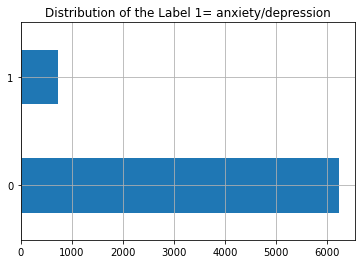

In [7]:
#Lets plot the label distribution
df.label.value_counts().plot(kind='barh')
plt.title("Distribution of the Label 1= anxiety/depression")
plt.grid()
plt.show()


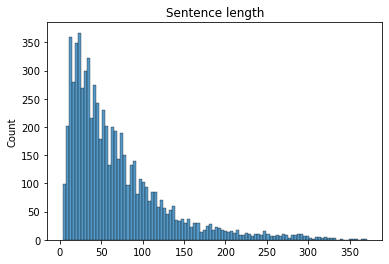

In [8]:
#Distribution of sentence lengths
sns.histplot([len(s) for s in df.text],bins=100)
plt.title("Sentence length")
plt.show()

* The distribution of sentence length is skewed to the right, with most sentences having a length of between 0 and 100.

## 3. Preprocessing of the text

In [9]:
#Create a function for Cleaning of text
def clean_text(text):
    #1. Align all cases to lower
    tolower = text.lower()
    #2.remove punctuations
    punct = ''.join([char for char in tolower if char not in string.punctuation])

    #3.remove any new lines
    #nospecial=[re.sub('\s+',' ',sent) for sent in punct]

    result = punct
    return(result)


In [10]:
#Create a function to remove stopwords
def get_tokens(text):
    #tokenize sentense to words
    words=word_tokenize(text)
    #remove stopwords
    nostops=[word for word in words if word not in stop_words]
    #stem the words
    stemed=[porter.stem(word) for word in nostops]
    result=stemed
    return(result)

In [11]:
#Apply the Cleaning functions on the data
df['text_clean']=df.text.apply(clean_text)
df.head(5)

,text,label,text_clean
0,oh my gosh,1,oh my gosh
1,"trouble sleeping, confused mind, restless heart. All out of tune",1,trouble sleeping confused mind restless heart all out of tune
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",1,all wrong back off dear forward doubt stay in a restless and restless place
3,I've shifted my focus to something else but I'm still worried,1,ive shifted my focus to something else but im still worried
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",1,im restless and restless its been a month now boy what do you mean


In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eunice\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
#Extract the tokens
df['tokens']=df.text_clean.apply(get_tokens)
#df['text_tokens'] = df.tokens.apply(lambda x : ' '.join(x))

In [14]:
# convert token list into text
df['text_tokens'] = df.tokens.apply(lambda x : ' '.join(x))

In [15]:
df.head(5)

,text,label,text_clean,tokens,text_tokens
0,oh my gosh,1,oh my gosh,"[oh, gosh]",oh gosh
1,"trouble sleeping, confused mind, restless heart. All out of tune",1,trouble sleeping confused mind restless heart all out of tune,"[troubl, sleep, confus, mind, restless, heart, tune]",troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",1,all wrong back off dear forward doubt stay in a restless and restless place,"[wrong, back, dear, forward, doubt, stay, restless, restless, place]",wrong back dear forward doubt stay restless restless place
3,I've shifted my focus to something else but I'm still worried,1,ive shifted my focus to something else but im still worried,"[ive, shift, focu, someth, els, im, still, worri]",ive shift focu someth els im still worri
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",1,im restless and restless its been a month now boy what do you mean,"[im, restless, restless, month, boy, mean]",im restless restless month boy mean


## 4. Create Wordclouds

In [16]:
text_0 = " " .join(t for t in df.text[df.label==0])
text_1 = " " .join(t for t in df.text[df.label==1])

In [17]:
#Add more stopwords to the list found after the wordcloud plot
stop_words_extra=stop_words
stop_words_extra.append("i'm")
stop_words_extra.append("i'll")
stop_words_extra.append("i've")
stop_words_extra.append("can't")
stop_words_extra.append('ðÿ')
stop_words_extra.append('â')
stop_words_extra.append('rt')

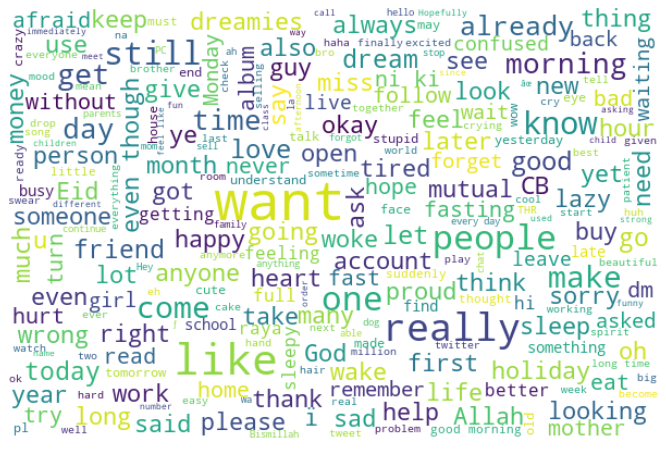

In [18]:
#Wordcloud for label 0
wordcloud1=WordCloud(stopwords=stop_words_extra,max_font_size=50, max_words= 250,width=600,
                    height=400,background_color='white').generate(text_0)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud1,interpolation='bilinear')
plt.axis('off')
plt.show()



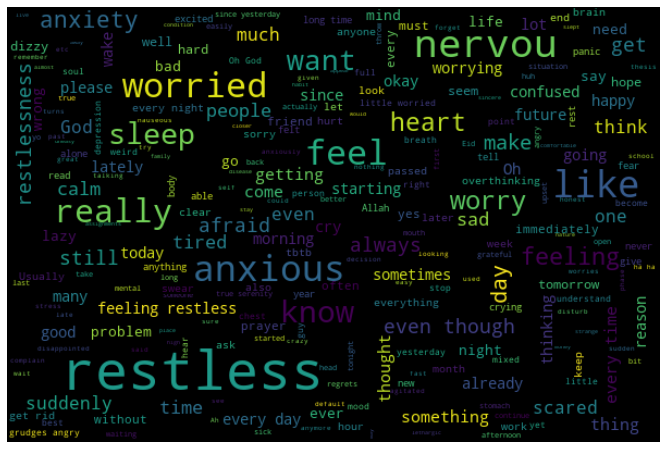

In [19]:
#Wordcloud for label 1
wordcloud1=WordCloud(stopwords=stop_words_extra,max_font_size=50, max_words= 250,width=600,
                    height=400,background_color='black').generate(text_1)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud1,interpolation='bilinear')
plt.axis('off')
plt.show()


## 5.Evaluation of Ngrams
* Ngrams are a combination of different words to make sense. Unigram is just one word as seen in the wordclouds
* Bigrams are two, trigrams are 3 and so forth

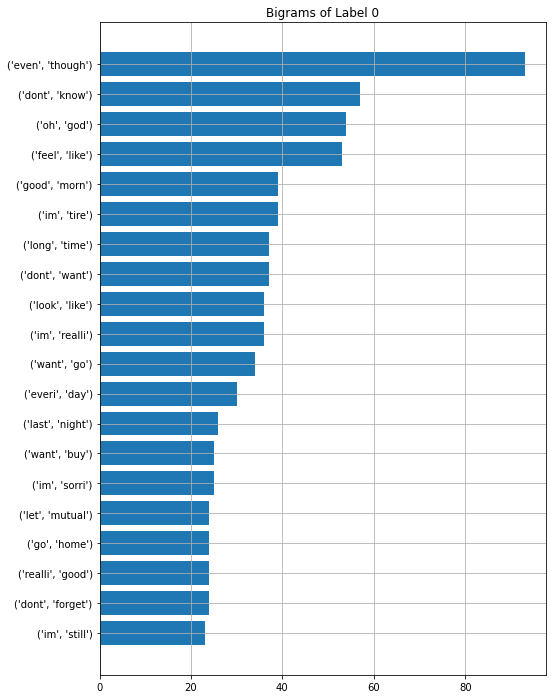

In [33]:
# create bigrams for label 0 by ceaning and generating tokens
bi_grams = bigrams(get_tokens(clean_text(text_0)))

#use counter to count
counts=Counter(bi_grams)
#create a dictionary to hold these
counts=dict(counts)


#convert this dictionary into a data frame
dcounts=pd.DataFrame.from_dict(counts,orient='index',columns=['frequency'])
#print(dcounts)
#Subset bigrams with a frequency of more than twice
dcounts=dcounts[dcounts.frequency >=3]
#print(dcounts.head(5))

dcounts=dcounts.sort_values(['frequency'], ascending=False)
#dcounts=dcounts.sort_values(by)
#plot the top 20 bigrams
top=20
plt.figure(figsize=(8,12))
top_bigrams=list(map(str, dcounts.index.tolist()))
plt.barh(y=top_bigrams[0:top] ,width=dcounts.frequency[0:top].values)
plt.title('Bigrams of Label 0')
plt.gca().invert_yaxis()  # To start with the highest
plt.grid()
plt.show()


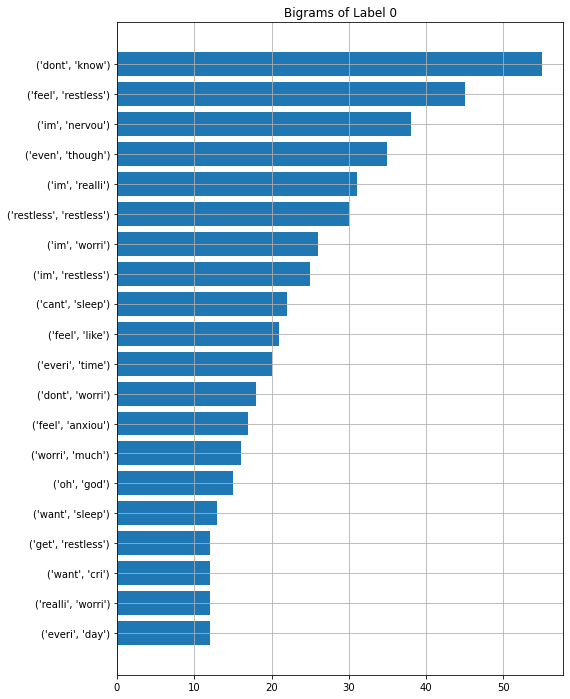

In [35]:
# create bigrams for label 1 by ceaning and generating tokens
bi_grams = bigrams(get_tokens(clean_text(text_1)))

#use counter to count
counts=Counter(bi_grams)
#create a dictionary to hold these
counts=dict(counts)


#convert this dictionary into a data frame
dcounts=pd.DataFrame.from_dict(counts,orient='index',columns=['frequency'])
#print(dcounts)
#Subset bigrams with a frequency of more than twice
dcounts=dcounts[dcounts.frequency >=3]
#print(dcounts.head(5))

dcounts=dcounts.sort_values(['frequency'], ascending=False)
#dcounts=dcounts.sort_values(by)
#plot the top 20 bigrams
top=20
plt.figure(figsize=(8,12))
top_bigrams=list(map(str, dcounts.index.tolist()))
plt.barh(y=top_bigrams[0:top] ,width=dcounts.frequency[0:top].values)
plt.title('Bigrams of Label 0')
plt.gca().invert_yaxis()  # To start with the highest
plt.grid()
plt.show()

## 6. Vectorizing the texts - convert text to numbers
* We shall use the TFIDF(Term Frequency Inverse Document Frequency) vectorizer

In [36]:
#fit tfidf on the tokenized text
max_feat=250
tfidf=TfidfVectorizer(max_features= max_feat)
tfidf=tfidf.fit_transform(df.text_tokens)

In [37]:
#convert the vector to a dataframe
column_names=['f' + str(i) for i in range(max_feat)]
tfidf_matrix_df=pd.DataFrame(tfidf.toarray(),columns=column_names)

In [38]:
#Combine the two data frames to 1
df=pd.concat([df, tfidf_matrix_df],axis=1)
df.head(5)

,text,label,text_clean,tokens,text_tokens,f0,f1,f2,f3,f4,...,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249
0,oh my gosh,1,oh my gosh,"[oh, gosh]",oh gosh,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"trouble sleeping, confused mind, restless heart. All out of tune",1,trouble sleeping confused mind restless heart all out of tune,"[troubl, sleep, confus, mind, restless, heart, tune]",troubl sleep confus mind restless heart tune,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",1,all wrong back off dear forward doubt stay in a restless and restless place,"[wrong, back, dear, forward, doubt, stay, restless, restless, place]",wrong back dear forward doubt stay restless restless place,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.431659,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I've shifted my focus to something else but I'm still worried,1,ive shifted my focus to something else but im still worried,"[ive, shift, focu, someth, els, im, still, worri]",ive shift focu someth els im still worri,0.0,0.0,0.0,0.0,0.0,...,0.435055,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",1,im restless and restless its been a month now boy what do you mean,"[im, restless, restless, month, boy, mean]",im restless restless month boy mean,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. Building the Classification Model
* We use h20 transformers

In [39]:
#Initialize h20
#Use a max of 10GB RAM and 4 cores
h2o.init(max_mem_size='10G',nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\Users\Eunice\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Eunice\AppData\Local\Temp\tmp2pew_0z8
  JVM stdout: C:\Users\Eunice\AppData\Local\Temp\tmp2pew_0z8\h2o_Eunice_started_from_python.out
  JVM stderr: C:\Users\Eunice\AppData\Local\Temp\tmp2pew_0z8\h2o_Eunice_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Africa/Nairobi
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,"28 days, 5 hours and 47 minutes"
H2O_cluster_name:,H2O_from_python_Eunice_yn8jz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.89 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [40]:
#Selecting predictors / x's/features
predictors=column_names
print('The number of predictors is : ', len(predictors))

The number of predictors is :  250


In [41]:
#Uploading the dataframe into the h2o environment
df_hex=h2o.H2OFrame(df[['text'] + predictors + ['label']])
#observe the parse progress

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
#Converting the Outcome variable to categorical
df_hex['label'] = df_hex['label'].asfactor()

#Split test and train data  70/30
train_hex ,test_hex = df_hex.split_frame(ratios=[0.7], seed = 123)

#convert to dataframes
df_train = train_hex.as_data_frame()
df_test = test_hex.as_data_frame()


In [44]:
#Enabling downloading of the data
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

### * Defining the Gradient Boosting model (GBM)


In [46]:
fit_1=H2OGradientBoostingEstimator(ntrees=25,max_depth=6,min_rows=15,learn_rate=0.005, # Default is 0.1
                                   sample_rate=1,col_sample_rate=0.5,nfolds=5,score_each_iteration=True,
                                   stopping_metric='AUC',stopping_rounds=5,seed=123)

In [47]:
#Now training the model
t1=time.time()
fit_1.train(x=predictors,y='label',training_frame=train_hex)
t2= time.time()
print('Time taken in seconds is : ',np.round(t2-t1,2))


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Time taken in seconds is :  6.03


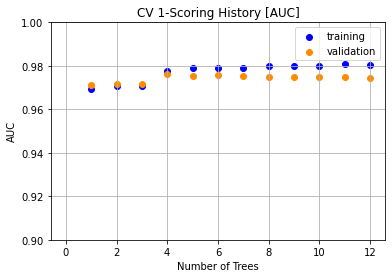

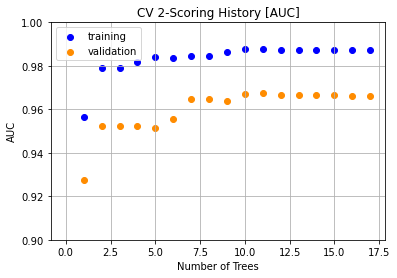

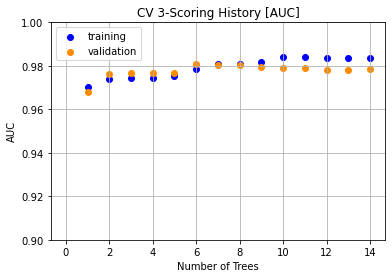

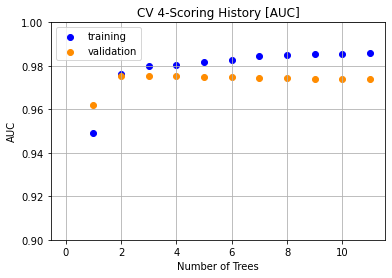

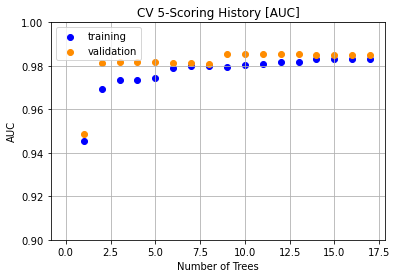

In [49]:
#Show scoring history of training versus validations
for i in range(5):
    cv_model_temp=fit_1.cross_validation_models()[i]
    df_cv_score_history = cv_model_temp.score_history()
    my_title = 'CV ' + str(1+i) + '-Scoring History [AUC]'
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.training_auc,
                c='blue',label='training')
    
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.validation_auc,
                c='darkorange',label ='validation')
    
    plt.title(my_title)
    plt.xlabel('Number of Trees')
    plt.ylabel('AUC')
    plt.ylim(0.9,1)
    plt.legend()
    plt.grid()
    plt.show()

### * Show all the Cross Validation Metrics

In [51]:
fit_1.cross_validation_metrics_summary()

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.9891956,0.0039483,0.9881423,0.9839680,0.9887641,0.9949187,0.9901854
auc,0.9756198,0.0068009,0.9745233,0.9662977,0.9784414,0.9739371,0.9848995
err,0.0108043,0.0039483,0.0118577,0.0160321,0.0112360,0.0050813,0.0098146
err_count,10.6,4.037326,12.0,16.0,11.0,5.0,9.0
f0point5,0.9501953,0.0240947,0.9337349,0.9277344,0.9486166,0.9894737,0.951417
f1,0.947189,0.0190738,0.9393939,0.9223301,0.9458128,0.9740933,0.9543147
f2,0.9443099,0.0168592,0.9451219,0.9169884,0.9430255,0.9591837,0.9572302
lift_top_group,9.763453,0.3769782,10.32653,9.596154,9.59804,9.939394,9.357142
logloss,0.2830142,0.0042128,0.2793793,0.2794185,0.2863559,0.2885724,0.2813448
max_per_class_error,0.0575408,0.0174229,0.0510204,0.0865385,0.0588235,0.0505051,0.0408163


### * Ploting the ROC Curves

In [ ]:
# Training perforance
performance_train = fit_1.model_performance(train = True)
performance_train.plot()

In [ ]:
# Cross validation performance
performance_cv=fit_1.model_performance(xval=True)
performance_cv.plot()

### * Variable / Feature Performance
* Out of the 250 variables, we want to know how many are important

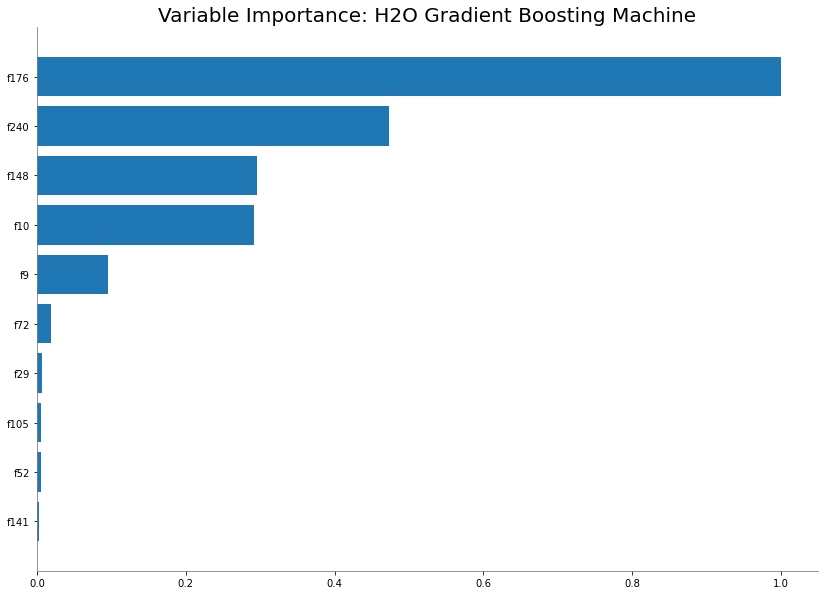

<Figure size 432x288 with 0 Axes>

In [56]:
fit_1.varimp_plot()

Elapsed time :  1.17


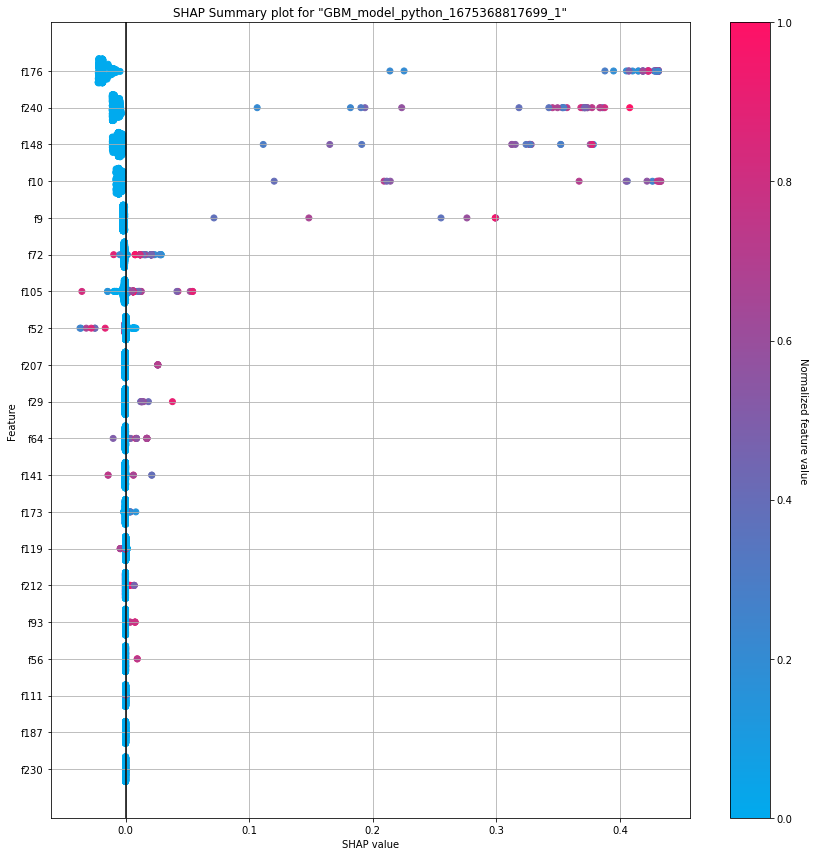

In [57]:
#Using SHAP values
t1 = time.time()
fit_1.shap_summary_plot(train_hex)
t2=time.time()
print('Elapsed time : ' , np.round(t2-t1,2))


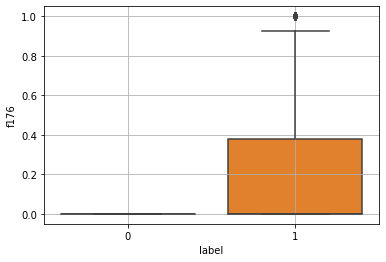

In [58]:
#Most significant / influential factors vs target
sns.boxplot(data=df,y='f176',x='label')
plt.grid()
plt.show()

### * Confussion Matrix

In [59]:
conf_train=fit_1.confusion_matrix(train=True)
conf_train.show()

,0,1,Error,Rate
0,4364.0,25.0,0.0057,(25.0/4389.0)
1,28.0,473.0,0.0559,(28.0/501.0)
Total,4392.0,498.0,0.0108,(53.0/4890.0)


In [60]:
#set a threshhold from training
thresh=0.1040779032060292

In [62]:
#Show confusion matrix at this threshhold for Cross validation
conf_cv_thresh=fit_1.confusion_matrix(xval=True,thresholds=thresh)
conf_cv_thresh.show()

Could not find exact threshold 0.1040779032060292; using closest threshold found 0.10424269805177126.


,0,1,Error,Rate
0,4361.0,28.0,0.0064,(28.0/4389.0)
1,29.0,472.0,0.0579,(29.0/501.0)
Total,4390.0,500.0,0.0117,(57.0/4890.0)


## Evaluating Model on Test Set

In [ ]:
performance_test=fit_1.model_performance(test_hex)

#ROC Curve
performance_test.plot()

In [64]:
conf_test = performance_test.confusion_matrix(thresholds=thresh)
conf_test.show()

Could not find exact threshold 0.1040779032060292; using closest threshold found 0.10332412492877117.


,0,1,Error,Rate
0,1842.0,9.0,0.0049,(9.0/1851.0)
1,14.0,215.0,0.0611,(14.0/229.0)
Total,1856.0,224.0,0.0111,(23.0/2080.0)


### Calculating Predictions

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


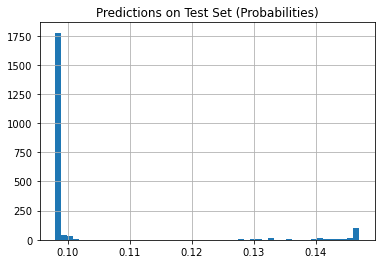

In [65]:
pred_test = fit_1.predict(test_hex)['p1']
pred_test = pred_test.as_data_frame().p1

# connect predictions with data frame
df_test['prediction'] = pred_test

# and plot
plt.hist(pred_test, bins=50)
plt.title('Predictions on Test Set (Probabilities)')
plt.grid()
plt.show()

In [66]:
# show highest predictions
df_top = df_test.nlargest(5, columns='prediction')
df_top[['text','label','prediction']]

,text,label,prediction
30,"Every time after sunset, why must this heart be restless as if it can't accept the situation. But with this situation, you can't do anything, if you do it, it can only make things worse",1,0.147059
115,"Why is it that if there are a lot of people talking in front of the house, there are too many motorbikes that pass by, the feeling is immediately restless, afraid, gt",1,0.147056
83,"They say I'm strong, I'm stoned, I always have panic attacks when I'm restless at night, it's not clear who knows, I don't leave my room all day because I'm so tired, I'm so tired, some people care, they say I'm lazy, even though they don't know why I'm like that. It seems like my mental health is not important",1,0.147051
101,Q: Does anyone know of a sedative so you don't get excited? I wake up restless every time I don't know why or do I have any other suggestions so that it doesn't continue like this. thank you,1,0.147051
61,"Come on, come on, let's go... 10 years could be passed before, it's not even a month yet, I'm already restless",1,0.147048


In [67]:
# show lowest predictions
df_bot = df_test.nsmallest(5, columns='prediction')
df_bot[['text','label','prediction']]

,text,label,prediction
105,Waiting anxiously,1,0.097878
118,Mama eto pera kan life e,1,0.097878
119,Hell yeah varsity life,1,0.097878
120,Porasonar mayre bap,1,0.097878
121,Baler question kore rakhce,1,0.097878
